## Imports and Custom Functions

In [16]:
#Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import nltk
import math
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import itertools
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth',300)

import joblib

from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

# Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [18]:
%load_ext autoreload 
%autoreload 2

    
# Adding folder above to python path 
import sys, os
sys.path.append(os.path.abspath("/custom_functions.py"))

In [19]:
import custom_functions as fn

## Load and Preprocess Data

In [8]:
df = joblib.load('Data-NLP/df_high_low_reviews-1')
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,joined_tokens,lemmas,joined_lemmas
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, com...",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossi...,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low poi...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m,...",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat l...,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie...",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece ...
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the ...,4.0,"[scream, 3, lackluster, screenplay, unimaginative, kills, leave, film, bore, watch, meta, narrative, trilogies, film, abysmal, plot, film, creates, lore, past, movies, seemingly, blue, muddling, continuity, shock, value, added, little, film, felt...",scream 3 lackluster screenplay unimaginative kills leave film bore watch meta narrative trilogies film abysmal plot film creates lore past movies seemingly blue muddling continuity shock value added little film felt forced entire plot point sidne...,"[scream, 3, lackluster, screenplay, unimaginative, kill, leave, film, bore, watch, meta, narrative, trilogy, film, abysmal, plot, film, create, lore, past, movie, seemingly, blue, muddle, continuity, shock, value, add, little, film, feel, force, ...",scream 3 lackluster screenplay unimaginative kill leave film bore watch meta narrative trilogy film abysmal plot film create lore past movie seemingly blue muddle continuity shock value add littl

In [9]:
df["rating"].isna().sum()

0

In [10]:
df_ml = df

In [11]:
def create_groups(x):
    if x<=4.0:
        return 0
    elif x >=5.0:
        return 1
    else: 
        return None

In [12]:
## Use the function to create a new "rating" column with groups
df_ml['high_low'] = df_ml['rating'].map(create_groups)
df_ml['high_low'].value_counts(dropna=False)

0    1224
1    1195
Name: high_low, dtype: int64

## Train Test Split

In [13]:
# Define X and y
X = df_ml['review']
y= df_ml["high_low"]

In [14]:
# Perform 70:30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train), len(X_test)

(1693, 726)

## Build Model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       839
           1       0.99      0.98      0.98       854

    accuracy                           0.98      1693
   macro avg       0.98      0.98      0.98      1693
weighted avg       0.98      0.98      0.98      1693



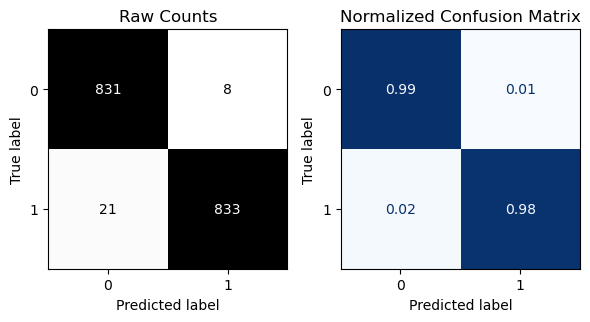


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       385
           1       0.85      0.88      0.86       341

    accuracy                           0.87       726
   macro avg       0.87      0.87      0.87       726
weighted avg       0.87      0.87      0.87       726



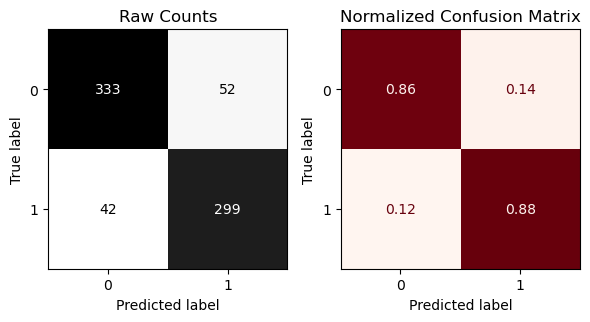

In [27]:
## Create a model pipeline 
text_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('clf',  MultinomialNB())])

text_pipe.fit(X_train, y_train)
fn.evaluate_classification(text_pipe, X_train, y_train, X_test, y_test,)

This model is pretty good with an overall 87% accuracy. It predicated both classes at about the same rate.

## Gridseacrh Text Vectorization

In [28]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]



In [29]:
# Define parameters to tune multiple models

param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]



In [30]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]



({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [31]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]



{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [32]:
%%time
# Create grid search
grid_search = GridSearchCV(text_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
CPU times: total: 56.4 s
Wall time: 10min 43s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectori...
                         {'clf': [LogisticRegression(C=10, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=2)],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

In [33]:
grid_search.best_params_



{'clf': LogisticRegression(C=10, random_state=42),
 'clf__C': 10,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       1.00      1.00      1.00       854

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



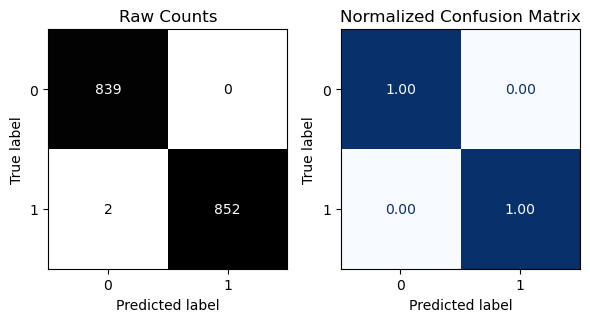


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       385
           1       0.88      0.90      0.89       341

    accuracy                           0.89       726
   macro avg       0.89      0.89      0.89       726
weighted avg       0.89      0.89      0.89       726



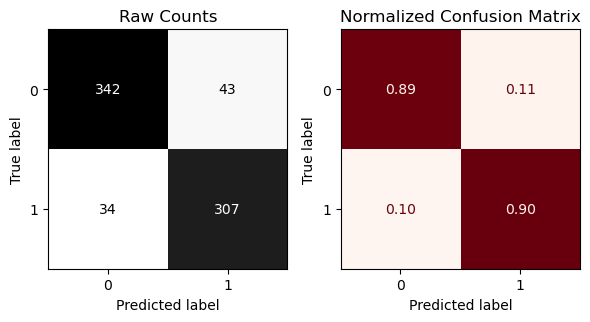

In [35]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)



In [36]:
joblib.dump(grid_search, "Models/Gridsearch_full")

['Models/Gridsearch_full']

In [38]:
joblib.dump(best_model, "Models/gridseacrh_89")

['Models/gridseacrh_89']

Below were the best parameters:

{'clf': LogisticRegression(C=10, random_state=42),
 'clf__C': 10,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf

 The above model performed perfectly on the train data and at 89% accuracy on the test data. So, it experienced a loss of 11% accuracy between the train and test data.': True}

## Deep NLP

In [39]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [40]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [41]:
# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [42]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)

In [43]:
## Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [44]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


In [45]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [47]:
# length of each document - Using a lambda function

df['sequence_length'] =df['review'].map( lambda x: len(x.split(" ")))
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,joined_tokens,lemmas,joined_lemmas,high_low,sequence_length
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, encouraging, bad, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation final rating: ★ ½ boring disappointing avoid possible,0,118
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m, movies, turned, better, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat lousy piece crap movie,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know f

In [48]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = max(df["sequence_length"])

In [49]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

25068

In [50]:
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 4017,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 25068}
)


In [51]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

25068

In [52]:
# Define output dimension
EMBED_DIM = 100
EMBED_DIM

100

In [53]:
# Defining an embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)

In [54]:
# Define classes variable
classes = y.unique()
classes

array([0, 1], dtype=int64)

In [55]:
# Fit the layer on the training texts
model = sequence_vectorizer.adapt(ds_texts)

In [56]:
def build_gru_model_stack_hierarchy_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(32, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



In [58]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 4017)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 4017, 100)         2506800   
                                                                 
 gru_3 (GRU)                 (None, 4017, 128)         88320     
                                                                 
 dropout_2 (Dropout)         (None, 4017, 128)         0         
                                                                 
 gru_4 (GRU)                 (None, 4017, 64)          37248     
                                                                 
 dropout_3 (Dropout)         (None, 4017, 64)          0         
                                                      

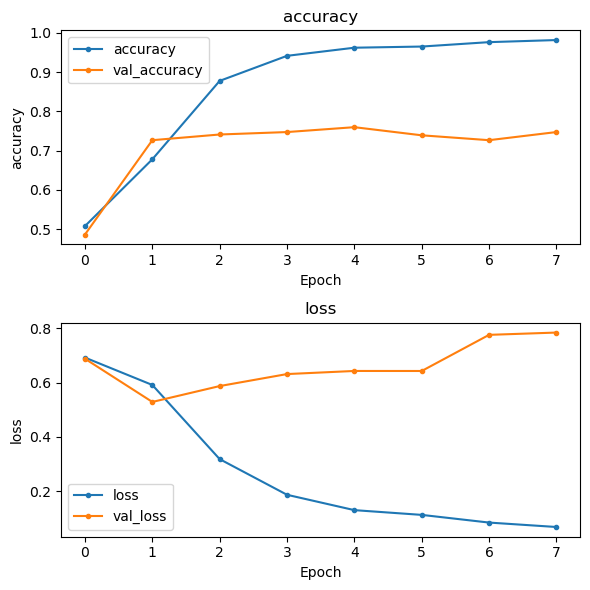


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.63      0.75       120
           1       0.72      0.93      0.82       123

    accuracy                           0.79       243
   macro avg       0.81      0.78      0.78       243
weighted avg       0.81      0.79      0.78       243



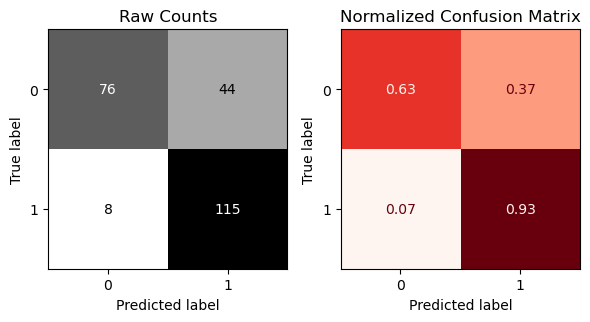


- Evaluating Test Data:
8/8 [==============================] - 7s 922ms/step - loss: 0.7392 - accuracy: 0.7860
{'loss': 0.7391692996025085, 'accuracy': 0.7860082387924194}


In [59]:
# Build model
model = build_gru_model_stack_hierarchy_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = evaluate_classification_network(
    model, 
    X_test=test_ds, history=history
);



In [62]:
def build_hybrid_model_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack   
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))     
    # For the final layer, use return_sequences = True for pooling layer
    model.add(layers.LSTM(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



In [ ]:
# Build model
model = build_hybrid_model_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 4017)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 4017, 100)         2506800   
                                                                 
 gru_7 (GRU)                 (None, 4017, 128)         88320     
                                                                 
 dropout_5 (Dropout)         (None, 4017, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 4017, 128)         131584    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                     

The stacked GRU RNN model was not better than my initial model. It was actually worse on all counts. Both of the RNN models also ran super slow which is unusual. I may need to tweak the models and make sure they are using all the cores available to them.